In [23]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from numpy.linalg import inv
from skimage.metrics import structural_similarity

np.random.seed(0)

In [24]:
def get_ball_pos(iimg=0):
    """Return measured position of ball by comparing with background image file.
        - References:
        (1) Data Science School:
            https://datascienceschool.net/view-notebook/f9f8983941254a34bf0fee42c66c5539
        (2) Image Diff Calculation:
            https://www.pyimagesearch.com/2017/06/19/image-difference-with-opencv-and-python
    """    
    imageA = cv2.imread('./Img/bg.jpg')
    imageB = cv2.imread('./Img/{}.jpg'.format(iimg+1))

    grayA = cv2.cvtColor(imageA, cv2.COLOR_BGR2GRAY)
    grayB = cv2.cvtColor(imageB, cv2.COLOR_BGR2GRAY)

    _, diff = structural_similarity(grayA, grayB, full=True)
    diff = (diff * 255).astype('uint8') 

    thresh = cv2.threshold(diff, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    M = cv2.moments(contours[0])
    xc = int(M['m10'] / M['m00'])  # center of x as true position.
    yc = int(M['m01'] / M['m00'])  # center of y as true position.

    v = np.random.normal(0, 15)  # v: measurement noise of position.

    xpos_meas = xc + v  # x_pos_meas: measured position in x (observable). 
    ypos_meas = yc + v  # y_pos_meas: measured position in y (observable). 

    return np.array([xpos_meas, ypos_meas])

In [25]:
def kalman_filter(z_meas, x_esti, P):
    """Kalman Filter Algorithm."""
    # (1) Prediction.
    x_pred = A @ x_esti
    P_pred = A @ P @ A.T + Q

    # (2) Kalman Gain.
    K = P_pred @ H.T @ inv(H @ P_pred @ H.T + R)

    # (3) Estimation.
    x_esti = x_pred + K @ (z_meas - H @ x_pred)

    # (4) Error Covariance.
    P = P_pred - K @ H @ P_pred

    return x_esti, P

In [26]:
# Input parameters.
n_samples = 24
dt = 1

In [27]:
# Initialization for system model.
# Matrix: A, H, Q, R, P_0
# Vector: x_0
A = np.array([[ 1, dt,  0,  0],
              [ 0,  1,  0,  0],
              [ 0,  0,  1, dt],
              [ 0,  0,  0,  1]])
H = np.array([[ 1,  0,  0,  0],
              [ 0,  0,  1,  0]])
Q = 2.0 * np.eye(4)
R = np.array([[50,  0],
              [ 0, 50]])

# Initialization for estimation.
x_0 = np.array([0, 0, 0, 0])  # (x-pos, x-vel, y-pos, y-vel) by definition in book.
P_0 = 100 * np.eye(4)

In [28]:
xpos_meas_save = np.zeros(n_samples)
ypos_meas_save = np.zeros(n_samples)
xpos_esti_save = np.zeros(n_samples)
ypos_esti_save = np.zeros(n_samples)

In [29]:
x_esti, P = None, None
for i in range(n_samples):
    z_meas = get_ball_pos(i)
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(z_meas, x_esti, P)

    xpos_meas_save[i] = z_meas[0]
    ypos_meas_save[i] = z_meas[1]
    xpos_esti_save[i] = x_esti[0]
    ypos_esti_save[i] = x_esti[2]

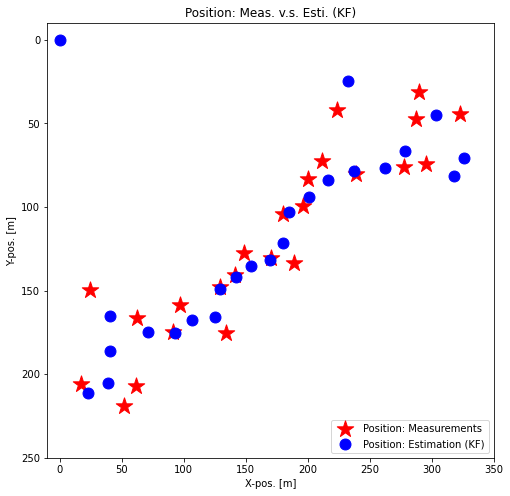

In [30]:
fig = plt.figure(figsize=(8, 8))
plt.gca().invert_yaxis()
plt.scatter(xpos_meas_save, ypos_meas_save, s=300, c="r", marker='*', label='Position: Measurements')
plt.scatter(xpos_esti_save, ypos_esti_save, s=120, c="b", marker='o', label='Position: Estimation (KF)')
plt.legend(loc='lower right')
plt.title('Position: Meas. v.s. Esti. (KF)')
plt.xlabel('X-pos. [m]')
plt.ylabel('Y-pos. [m]')
plt.xlim((-10, 350))
plt.ylim((250, -10))
plt.savefig('png/object_tracking_kf.png')

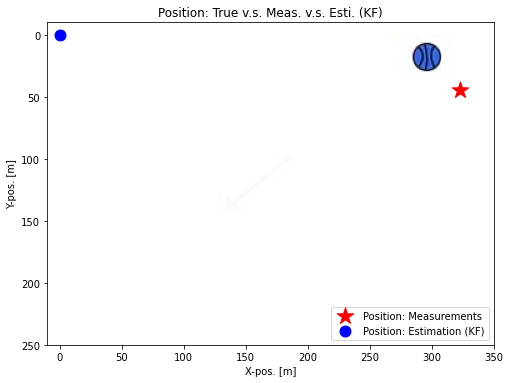

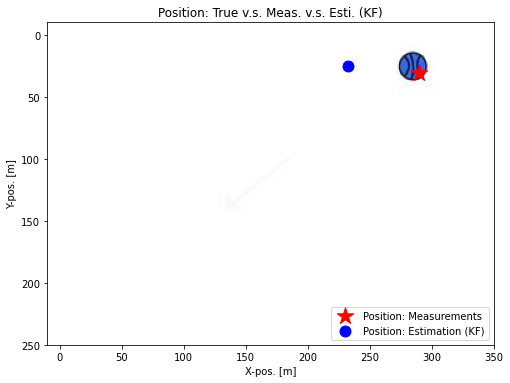

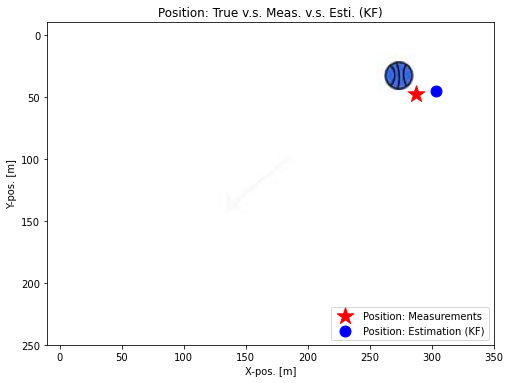

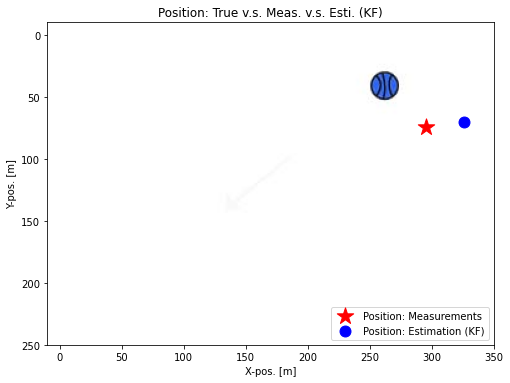

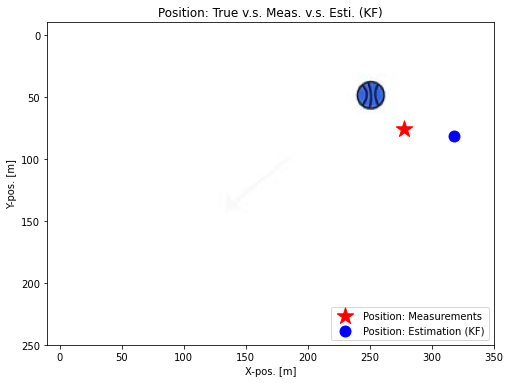

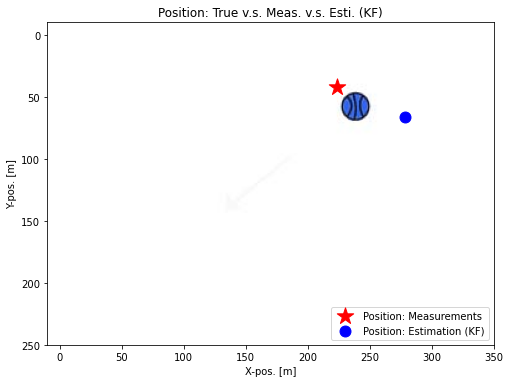

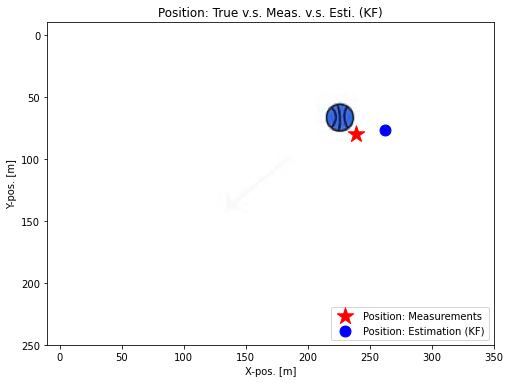

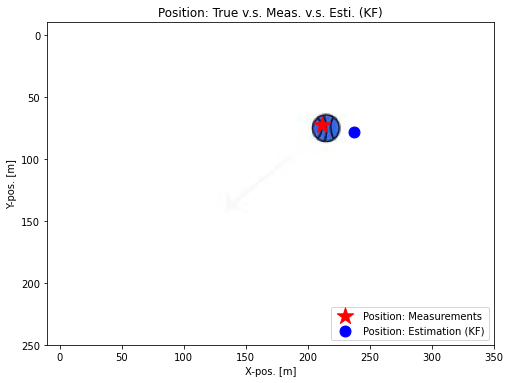

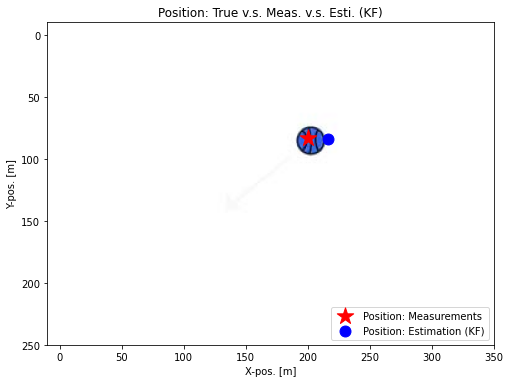

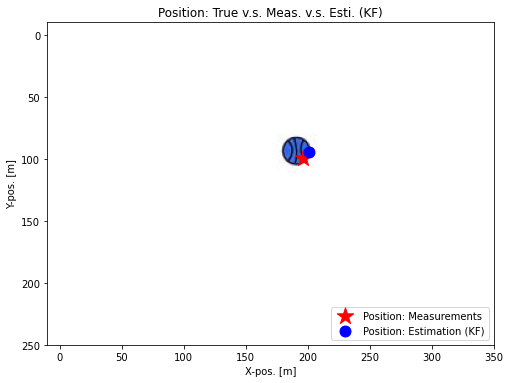

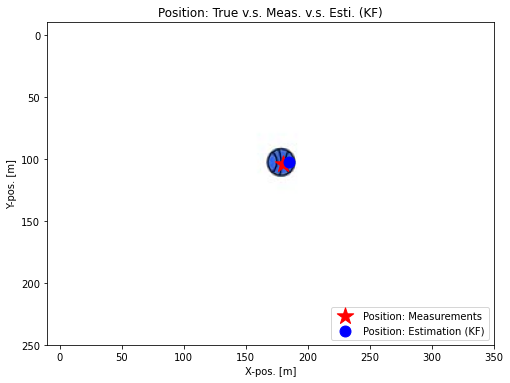

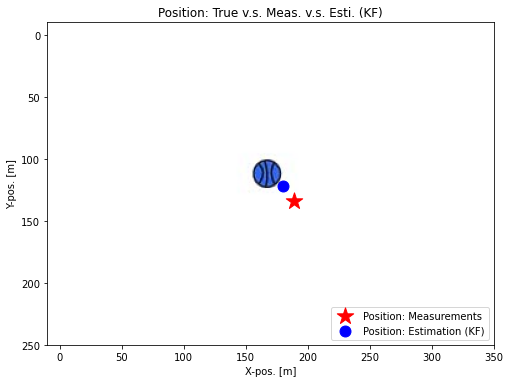

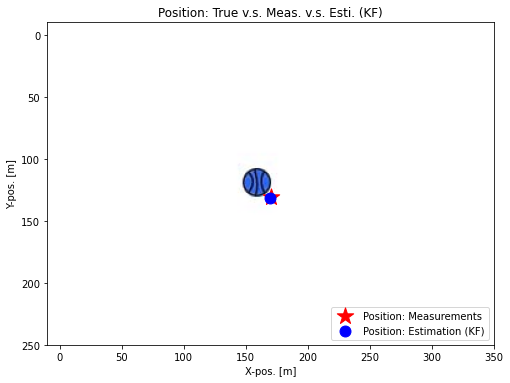

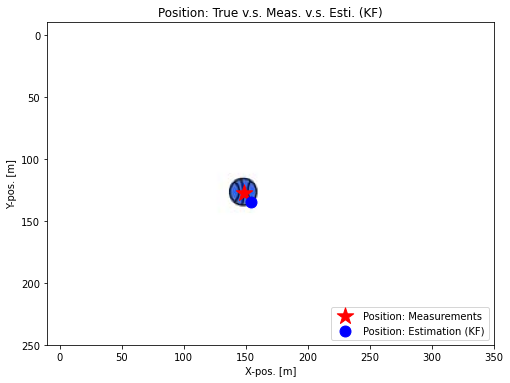

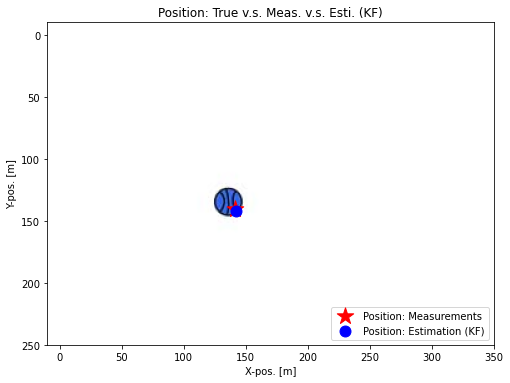

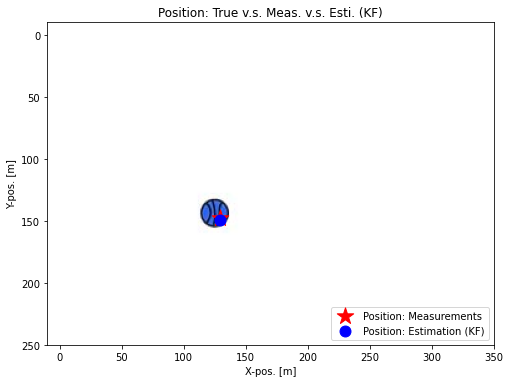

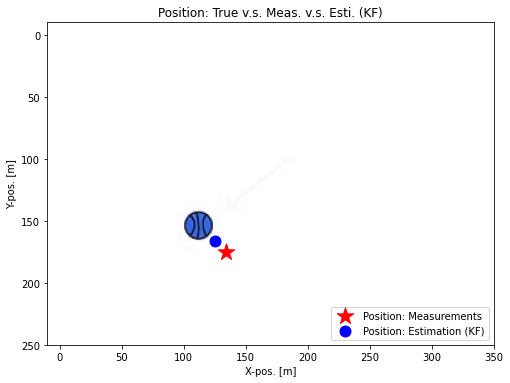

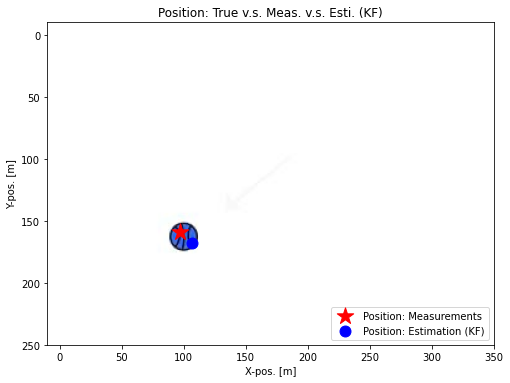

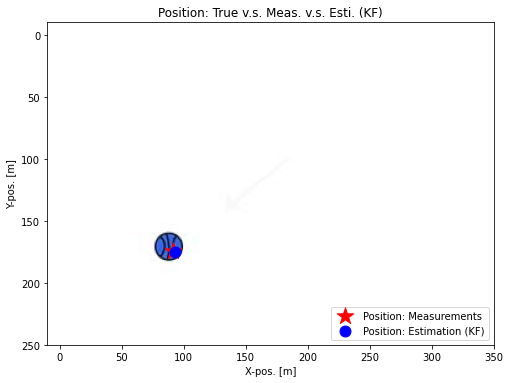

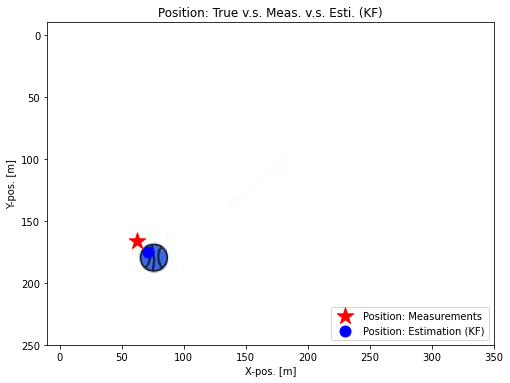

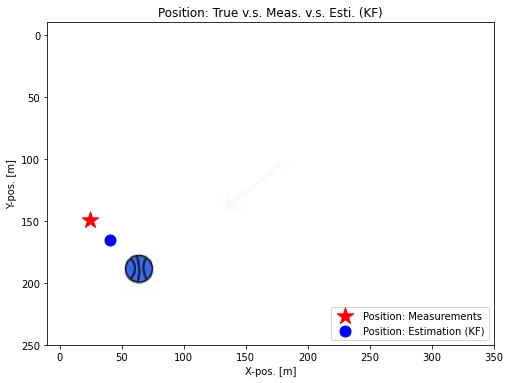

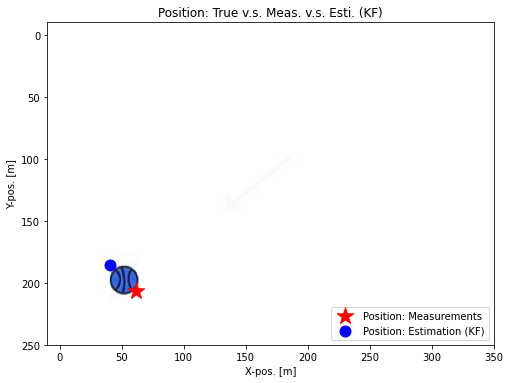

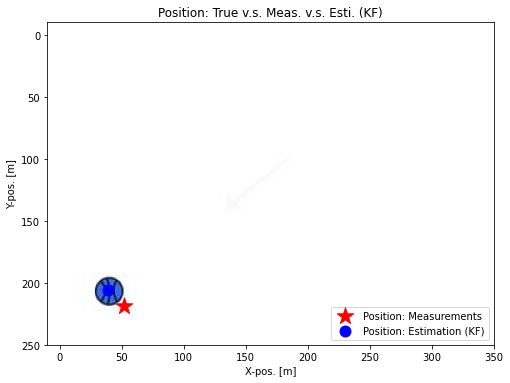

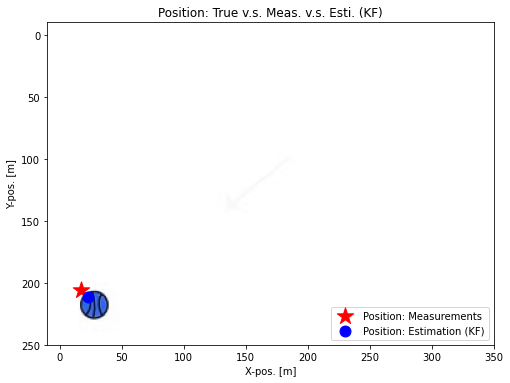

In [31]:
plt.ion()    
for i in range(n_samples):
    fig = plt.figure(figsize=(8, 8))    
    image = cv2.imread('./Img/{}.jpg'.format(i+1))
    imgplot = plt.imshow(image)
    plt.scatter(xpos_meas_save[i], ypos_meas_save[i], s=300, c="r", marker='*', label='Position: Measurements')
    plt.scatter(xpos_esti_save[i], ypos_esti_save[i], s=120, c="b", marker='o', label='Position: Estimation (KF)')
    plt.legend(loc='lower right')
    plt.title('Position: True v.s. Meas. v.s. Esti. (KF)')
    plt.xlabel('X-pos. [m]')
    plt.ylabel('Y-pos. [m]')
    plt.xlim((-10, 350))
    plt.ylim((250, -10))
    fig.canvas.draw()
    plt.savefig('png/object_tracking_kf{}.png'.format(i+1))
    plt.pause(0.05)